<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#In-this-notebook" data-toc-modified-id="In-this-notebook-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>In this notebook</a></span></li><li><span><a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data cleaning</a></span></li><li><span><a href="#Efficient-frontier-calculation" data-toc-modified-id="Efficient-frontier-calculation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Efficient frontier calculation</a></span><ul class="toc-item"><li><span><a href="#Building-the-log-returns" data-toc-modified-id="Building-the-log-returns-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Building the log-returns</a></span></li><li><span><a href="#Stationarity-check" data-toc-modified-id="Stationarity-check-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Stationarity check</a></span></li><li><span><a href="#Mean-variance-frontier-construction" data-toc-modified-id="Mean-variance-frontier-construction-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Mean-variance frontier construction</a></span></li><li><span><a href="#Stability-in-time" data-toc-modified-id="Stability-in-time-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Stability in time</a></span></li></ul></li></ul></div>

# Mean variance frontier with market data
** Camilo A. Garcia Trillos 2020**

## In this notebook 

We revisit the mean-variance frontier construction, this time using market data. We use a sub-sample of data, belonging to a selection of stocks in the market.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import ceil

## Data cleaning

We start by reading in data

In [13]:
data = pd.read_csv('~/Data/basket_20171201_10y.csv')


This corresponds to 10 years of daily information for a selection of assets.

First of all, we need to summarise, understand, visualize and clean the data. Let us look first at the different entries and their types:

In [14]:
data.dtypes

ticker          object
date            object
open           float64
high           float64
low            float64
close          float64
volume         float64
ex-dividend    float64
split_ratio    float64
adj_open       float64
adj_high       float64
adj_low        float64
adj_close      float64
adj_volume     float64
dtype: object

Note that once again the 'date' field is not recognised as a data but as an object. Let us have a look at how it looks before we decide to transform it

In [4]:
data.head()

,ticker,date,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
0,BAC,2007-01-03,53.40,54.18,52.99,53.33,16028200.0,0.0,1.0,44.077816,44.721649,43.739391,44.020036,16028200.0
1,BAC,2007-01-04,53.33,53.89,53.05,53.67,13175000.0,0.0,1.0,44.020036,44.482276,43.788917,44.300682,13175000.0
2,BAC,2007-01-05,53.59,53.59,53.03,53.24,10205000.0,0.0,1.0,44.234647,44.234647,43.772408,43.945748,10205000.0
3,BAC,2007-01-08,53.46,53.64,52.80,53.45,9685900.0,0.0,1.0,44.127342,44.275919,43.582560,44.119088,9685900.0
4,BAC,2007-01-09,53.60,53.71,52.97,53.50,12546500.0,0.0,1.0,44.242902,44.333699,43.722882,44.160359,12546500.0


It does look like a date with the format 'yyy-mm-dd'. We can then transform this field and update it.

In [15]:
data['date']=pd.to_datetime(data['date'], yearfirst=True)

Let us check that it looks the same, but that the field is now a date

In [16]:
data.head()

,ticker,date,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
0,BAC,2007-01-03,53.40,54.18,52.99,53.33,16028200.0,0.0,1.0,44.077816,44.721649,43.739391,44.020036,16028200.0
1,BAC,2007-01-04,53.33,53.89,53.05,53.67,13175000.0,0.0,1.0,44.020036,44.482276,43.788917,44.300682,13175000.0
2,BAC,2007-01-05,53.59,53.59,53.03,53.24,10205000.0,0.0,1.0,44.234647,44.234647,43.772408,43.945748,10205000.0
3,BAC,2007-01-08,53.46,53.64,52.80,53.45,9685900.0,0.0,1.0,44.127342,44.275919,43.582560,44.119088,9685900.0
4,BAC,2007-01-09,53.60,53.71,52.97,53.50,12546500.0,0.0,1.0,44.242902,44.333699,43.722882,44.160359,12546500.0


In [8]:
data.dtypes

ticker                 object
date           datetime64[ns]
open                  float64
high                  float64
low                   float64
close                 float64
volume                float64
ex-dividend           float64
split_ratio           float64
adj_open              float64
adj_high              float64
adj_low               float64
adj_close             float64
adj_volume            float64
dtype: object

Let su check if elements are unique per date. 

In [9]:
print( len(np.unique(data['date'])),  len(data['date']))

2749 24741


Not equal... because we have several indices. So this time the index should be a combination of ticker and date. However, since we are going to work fron now on only with adjusted_close prices, an alternative is to "pivot" the table, so that the 'ticker', which identifies the asset, becomes now another entry.

In [10]:
P = data.pivot(index='date', columns='ticker', values='adj_close')
P.head()

ticker,BAC,C,GE,JNJ,MSFT,PG,T,WMT,XOM
date,,,,,,,,,
2007-01-03,44.020036,484.789018,25.827146,47.613096,22.969861,46.463307,19.568303,36.764375,55.121310
2007-01-04,44.300682,483.121870,25.677502,48.208260,22.931399,46.110549,19.316351,36.942205,54.087460
2007-01-05,43.945748,480.577276,25.548264,47.770850,22.800626,45.714596,19.014008,36.640668,54.474224
2007-01-08,44.119088,483.034125,25.541462,47.691973,23.023709,45.815384,19.128786,36.339130,54.035396
2007-01-09,44.160359,478.822383,25.541462,47.512707,23.046786,45.700197,19.202336,36.640668,53.618881


The dataframe 'P' has only information of the 'adjusted close price' for each date for each one of the companies that are in the database, namely BAC (Bank of America), C (Citybank), GE (General Electric), JNJ (Johnson and Johnson), MSFT (Microsoft), PG (Proctor & Gamble), T (AT&T), WMT (Wallmart), and XOM (Exxon Mobile). All of these are large companies from different economic sectors including finance, technology, energy, retail and pharmaceutical.

Let us check that we did not loose any data when creating our pivot table.

In [17]:
P.isnull().any()

ticker
BAC     False
C       False
GE      False
JNJ     False
MSFT    False
PG      False
T       False
WMT     False
XOM     False
dtype: bool

No null data, so all fields are complete. Now, let us check that the data makes sense visually. 

<AxesSubplot:xlabel='date'>

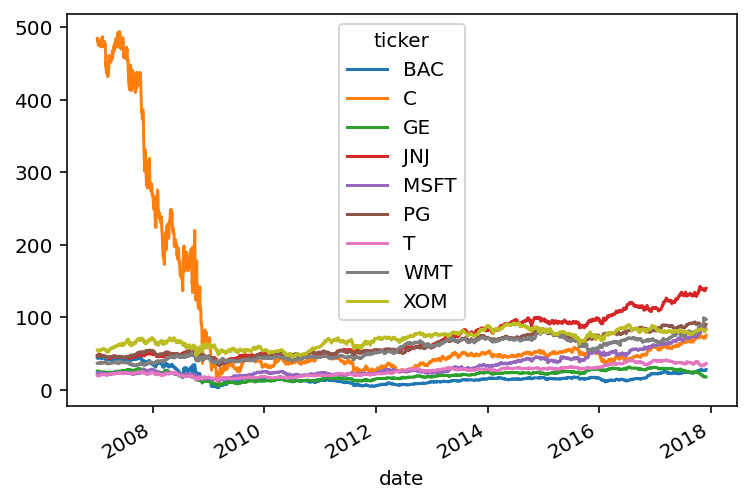

In [18]:
P.plot()

That 'C' line look suspicious... until we realise it belongs to Citygroup: a huge drop in between 2008-2010 is not so starnge if we think about the financial crisis of the time.

## Efficient frontier calculation

We are now going to build the efficient frontier in this reduced portfolio.

- Using one week as your period, find the mean_variance frontier if we assume that these are all the stocks on the market, and only using information before 01/01/2012.
- We find the minimal variance portfolio (note there is no risk free asset).


### Building the log-returns

Let us now resample using only weekly data...

In [19]:
P=P.resample('W-FRI').last()
P.head()

ticker,BAC,C,GE,JNJ,MSFT,PG,T,WMT,XOM
date,,,,,,,,,
2007-01-05,43.945748,480.577276,25.548264,47.770850,22.800626,45.714596,19.014008,36.640668,54.474224
2007-01-12,44.061308,477.155236,25.772730,47.785192,24.008351,46.794468,19.649297,37.096840,54.042834
2007-01-19,44.234647,478.208171,25.133343,48.588304,23.931426,47.804842,19.841660,37.351987,54.689920
2007-01-26,42.955235,479.699830,24.534768,47.376465,23.539108,46.915146,20.594138,36.857156,54.749422
2007-02-02,43.533034,484.344234,24.670808,47.742168,23.223714,47.262344,21.567268,37.174157,56.184911


In [20]:
type(P)

pandas.core.frame.DataFrame

Replot to check we did not do anything wrong

<AxesSubplot:xlabel='date'>

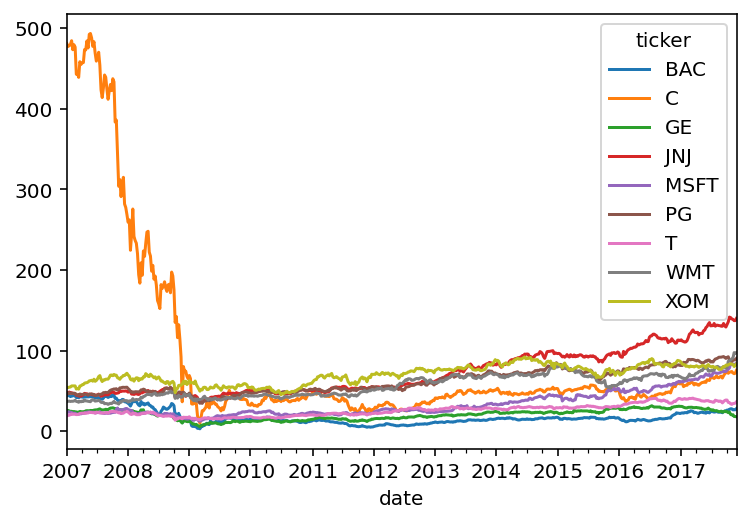

In [21]:
P.plot()

Good. Now, let us calculate both the returns and the log-returns.

In [23]:
logR=np.log(P).diff()
logR.drop(logR.index[0],inplace=True) # We drop the first line which produces NAN
logR.head()

ticker,BAC,C,GE,JNJ,MSFT,PG,T,WMT,XOM
date,,,,,,,,,
2007-01-12,0.002626,-0.007146,0.008748,0.000300,0.051614,0.023347,0.032866,0.012373,-0.007951
2007-01-19,0.003926,0.002204,-0.025122,0.016667,-0.003209,0.021362,0.009742,0.006854,0.011902
2007-01-26,-0.029350,0.003114,-0.024104,-0.025257,-0.016529,-0.018786,0.037223,-0.013336,0.001087
2007-02-02,0.013362,0.009635,0.005529,0.007689,-0.013489,0.007373,0.046170,0.008564,0.025881
2007-02-09,0.004729,-0.023321,-0.020614,-0.014829,-0.040905,-0.014025,-0.032528,-0.002290,0.000024


In [26]:
logR.head()

ticker,BAC,C,GE,JNJ,MSFT,PG,T,WMT,XOM
date,,,,,,,,,
2007-01-12,0.002626,-0.007146,0.008748,0.000300,0.051614,0.023347,0.032866,0.012373,-0.007951
2007-01-19,0.003926,0.002204,-0.025122,0.016667,-0.003209,0.021362,0.009742,0.006854,0.011902
2007-01-26,-0.029350,0.003114,-0.024104,-0.025257,-0.016529,-0.018786,0.037223,-0.013336,0.001087
2007-02-02,0.013362,0.009635,0.005529,0.007689,-0.013489,0.007373,0.046170,0.008564,0.025881
2007-02-09,0.004729,-0.023321,-0.020614,-0.014829,-0.040905,-0.014025,-0.032528,-0.002290,0.000024


<AxesSubplot:xlabel='date'>

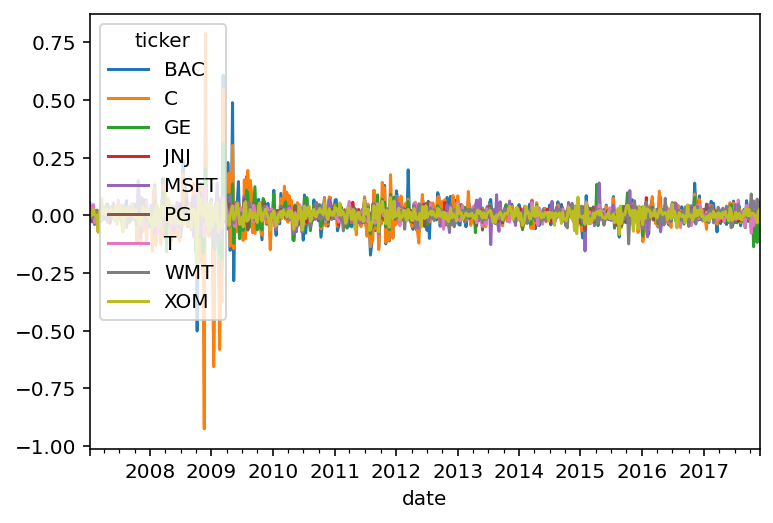

In [27]:
logR.plot()

Remember that negative results of log-returns means returns lower then 1 (i.e. effective losses)

### Stationarity check

How stationary are the data? Let us look first at the log-returns. I will simply plot the mean and variance  with a rolling window of 10 observations.

Text(0.5, 1.0, 'Log returns')

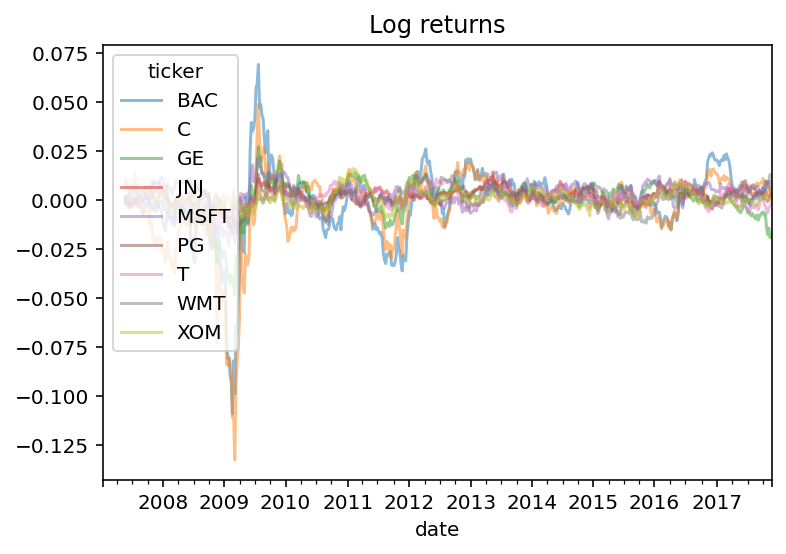

In [33]:
logR.rolling(20).mean().plot(alpha=0.5)
plt.title('Log returns')

These values seem to be significantly bigger initially. What about standard deviation?

<AxesSubplot:xlabel='date'>

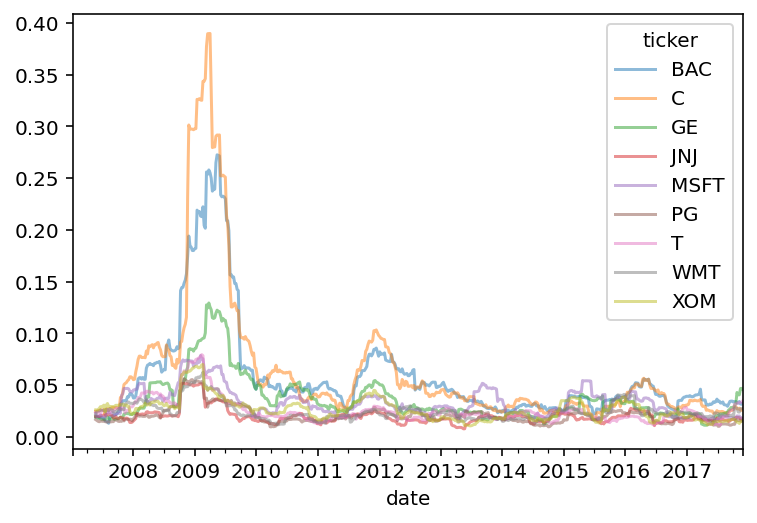

In [34]:
logR.rolling(20).std().plot(alpha=0.5)

It looks that there is a significant ``change of regime'' around 2010. It is of course associated with the results of the financial crisis. We are going to consider first the mean variance using the entire history from 2007 to 2010 and then compare with the result from 2010 on.

Note: In class we worked with mean-varaince analysis of returns. It is often convenient to work with log-retunrs instead: on the one hand, log-returns are usually closer to sattionary. On the other hand, they tend to look closer to Gaussian

### Mean-variance frontier construction

We start by calculating, the mean and variance for the selected history on the first case

In [35]:
logR_sub = logR[logR.index< '2012-01-01']
mu = logR_sub.mean()
Sigma = logR_sub.cov()
Rho = logR_sub.corr()

print('Mean:', mu)
print('Variances', np.diag(Sigma))
print('Var-cov:', Sigma)
print('Correlation', Rho)

Mean: ticker
BAC    -0.008158
C      -0.011287
GE     -0.002101
JNJ     0.000542
MSFT   -0.000119
PG      0.000720
T       0.000589
WMT     0.001307
XOM     0.000983
dtype: float64
Variances [0.01065754 0.01643106 0.00302104 0.00060041 0.00164302 0.00067786
 0.00114917 0.0008024  0.00119484]
Var-cov: ticker       BAC         C        GE       JNJ      MSFT        PG         T  \
ticker                                                                         
BAC     0.010658  0.010821  0.003996  0.001206  0.001436  0.001176  0.001680   
C       0.010821  0.016431  0.004706  0.001277  0.001674  0.001060  0.002169   
GE      0.003996  0.004706  0.003021  0.000551  0.000855  0.000614  0.000794   
JNJ     0.001206  0.001277  0.000551  0.000600  0.000493  0.000410  0.000463   
MSFT    0.001436  0.001674  0.000855  0.000493  0.001643  0.000460  0.000587   
PG      0.001176  0.001060  0.000614  0.000410  0.000460  0.000678  0.000492   
T       0.001680  0.002169  0.000794  0.000463  0.000587  

Correlation are positive as expected... means seem reasonable. 

Before calculating the optimal portfolio, we transform the variable Sigma in a numpy matrix and calculate its condition number to establish the stability of its inverse.

In [36]:
Sigma=Sigma.values
np.linalg.cond(Sigma)

128.7153892613439

It is a large number, but still OK. We do not need to stabilise the inverse. 

Now, we are going to re-define the Markowitz weights function to find the mean-variance frontier.

In [37]:
def Markowitz_weights(Sigma, mean_returns, mu_p):
    S_inv = np.linalg.inv(Sigma)
    pi_mu = S_inv @ (mean_returns)/sum(S_inv @ mean_returns)
    pi_1 = np.sum(S_inv, axis = 1) / sum(np.sum(S_inv, axis = 1) )
    lambda_demoninator = (mean_returns @ pi_mu) - (mean_returns@pi_1)
    ll = np.array((mu_p - (mean_returns @ pi_1))/lambda_demoninator)
    # previous line: to convert into array in case that mu_p is a single number
    ll.shape=(ll.size,1)
    return pi_mu * ll + pi_1 * (1-ll)

In [41]:
# Using the function: note that Sigma and mean are Series, so we turn them into arrays by using the property 'values'
print(mu)
print('======')
#mup= np.linspace(0.999,1.003) 
mup= np.linspace(-0.002,0.004)
mvf_portfolios = Markowitz_weights(Sigma, mu,mup )
print(mvf_portfolios[0:3])

ticker
BAC    -0.008158
C      -0.011287
GE     -0.002101
JNJ     0.000542
MSFT   -0.000119
PG      0.000720
T       0.000589
WMT     0.001307
XOM     0.000983
dtype: float64
[[ 0.04274296  0.15931801  0.02639219  0.59758119  0.20169459  0.41534182
  -0.14901258 -0.06063188 -0.23342629]
 [ 0.03794259  0.15316594  0.02884724  0.59361264  0.19470381  0.40944844
  -0.14098252 -0.05195897 -0.22477917]
 [ 0.03314222  0.14701386  0.03130228  0.5896441   0.18771302  0.40355506
  -0.13295245 -0.04328606 -0.21613205]]


Let us calculate the means and variances of those portfolios.

In [43]:
mu_mvf = mvf_portfolios @ mu
sd_mvf = np.diag((( mvf_portfolios @ Sigma) @ mvf_portfolios.T ))**0.5



We can also calculate the portfolio with the (quasi-) minimal variance portfolio

Index(['BAC', 'C', 'GE', 'JNJ', 'MSFT', 'PG', 'T', 'WMT', 'XOM'], dtype='object', name='ticker')
[-0.09416917 -0.01614631  0.0964129   0.48439373  0.00230924  0.24725583
  0.08001433  0.18672968  0.01319977]


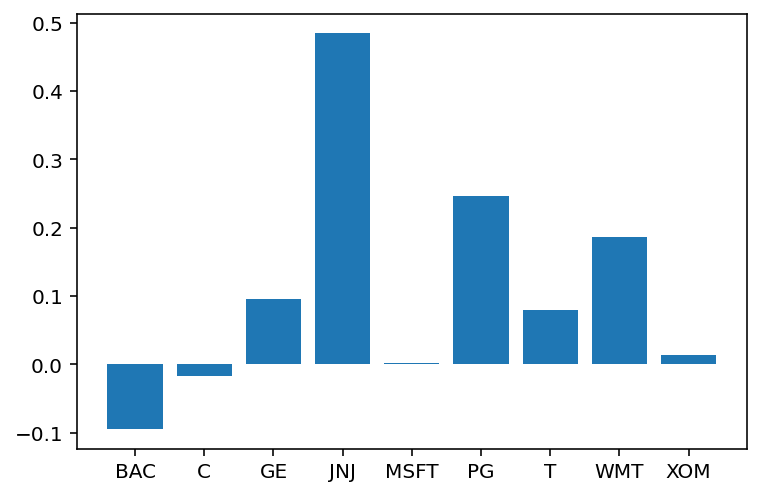

In [44]:
sigma_inv = np.linalg.inv(Sigma)
ones_vec = np.ones(Sigma.shape[0])
min_var_p =  sigma_inv@ones_vec
min_var_p/=min_var_p.sum()
plt.bar(R.columns, min_var_p)
print(R.columns)
print(min_var_p)

So that the minimal variance portfolio invests mostly on health and consumption (Johnson and Johnson, Proctor and Gamble, and Wallmart). Note that this is a risky strategy because it is too centered on one type of asset.

Let us check that everything is correct. We plot our surface and the minimum variance portfolio. To do so, we generate a bunch of random portfolios to visually verify that our calculated values are right.

0.02063705581048089 0.001492388376839055


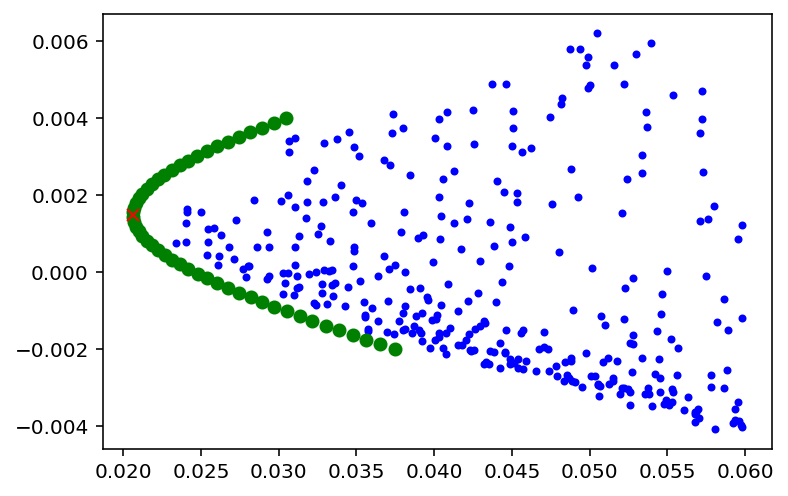

In [45]:
#Generating random portfolios
random_portfolios = 2.*np.random.rand(1000,Sigma.shape[0]) -1
random_portfolios/= random_portfolios.sum(axis=1)[..., np.newaxis]
rand_mean = np.dot(random_portfolios, mu)
rand_sd = np.diag((random_portfolios@Sigma)@random_portfolios.T)**0.5
rand_sd

#Calculating mean and variance of minimal variance portfolio
min_var_mean = np.dot(min_var_p, mu)
min_var_sd = min_var_p.dot(Sigma).dot(min_var_p.T)**0.5
print(min_var_sd, min_var_mean)
max_sd_plot=0.06

#Making the plot
plt.plot(rand_sd[rand_sd <max_sd_plot], rand_mean[rand_sd < max_sd_plot], 'b.')
plt.plot(sd_mvf, mu_mvf, 'go')
plt.plot(min_var_sd, min_var_mean, 'rx')

### Stability in time

What happens if we consider only recent history? If we had perfect stationarity, the optimal should still be very close to the one we found in the previous part. Let us make some calculations



Mean: [-0.00950856 -0.00219951  0.00220996  0.00085082 -0.00109434  0.00151515
  0.00188769  0.00155423  0.00257817]
Variances [0.00311498 0.00377738 0.00168709 0.00036972 0.00095914 0.00035433
 0.00046654 0.00036697 0.00091758]
Var-cov: [[0.00311498 0.00284224 0.00164264 0.00047208 0.00086103 0.00042768
  0.00067589 0.00043497 0.00107392]
 [0.00284224 0.00377738 0.00180427 0.00052624 0.00108874 0.00050054
  0.00083692 0.00047916 0.001286  ]
 [0.00164264 0.00180427 0.00168709 0.00041486 0.00086875 0.00044694
  0.00058337 0.00046338 0.00093544]
 [0.00047208 0.00052624 0.00041486 0.00036972 0.00028924 0.00019963
  0.00021918 0.00016211 0.00036518]
 [0.00086103 0.00108874 0.00086875 0.00028924 0.00095914 0.00029394
  0.00037959 0.00031198 0.00062288]
 [0.00042768 0.00050054 0.00044694 0.00019963 0.00029394 0.00035433
  0.00023336 0.00021372 0.00033215]
 [0.00067589 0.00083692 0.00058337 0.00021918 0.00037959 0.00023336
  0.00046654 0.00022388 0.00044079]
 [0.00043497 0.00047916 0.00046338

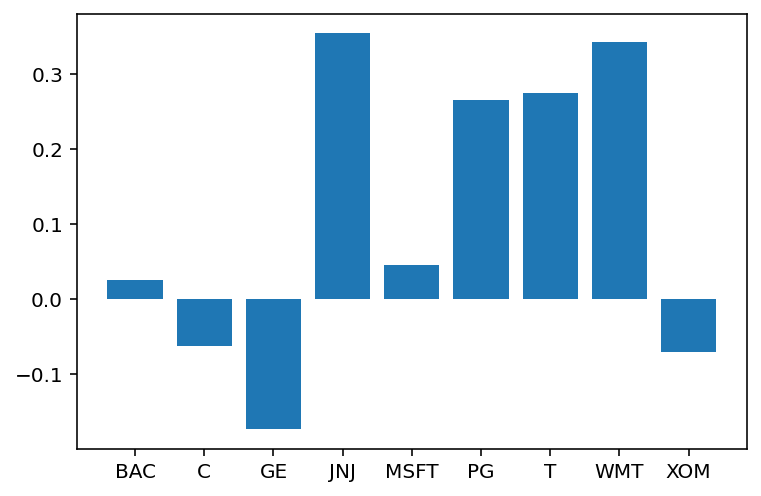

In [46]:
logR_sub2 = logR[(logR.index< '2012-01-01') & (logR.index> '2010-01-01')]
mu2 = logR_sub2.mean().values
Sigma2 = logR_sub2.cov().values
Rho2 = logR_sub2.corr().values

print('Mean:', mu2)
print('Variances', np.diag(Sigma2))
print('Var-cov:', Sigma2)
print('Correlation', Rho2)

mvf_portfolios2 = Markowitz_weights(Sigma2, mu2, mup)
mu2_mvf = mvf_portfolios2 @ mu2
sd2_mvf = np.diag((( mvf_portfolios2 @ Sigma2) @ mvf_portfolios2.T ))**0.5

print(np.linalg.cond(Sigma2))
sigma2_inv = np.linalg.inv(Sigma2)
ones_vec = np.ones(Sigma2.shape[0])
min_var_p2 =  sigma2_inv@ones_vec
min_var_p2/=min_var_p2.sum()
plt.bar(R.columns, min_var_p2)
print(R.columns)
print(min_var_p2)


The first big change is that in the minimal variance portfolio, there is no longer room for a positive position in GE or Exxon Mobile. On the other hand Bank of America makes its comeback: Note also the reduction in exposition to JNJ.

0.013923096082564245 0.0010427265331609799


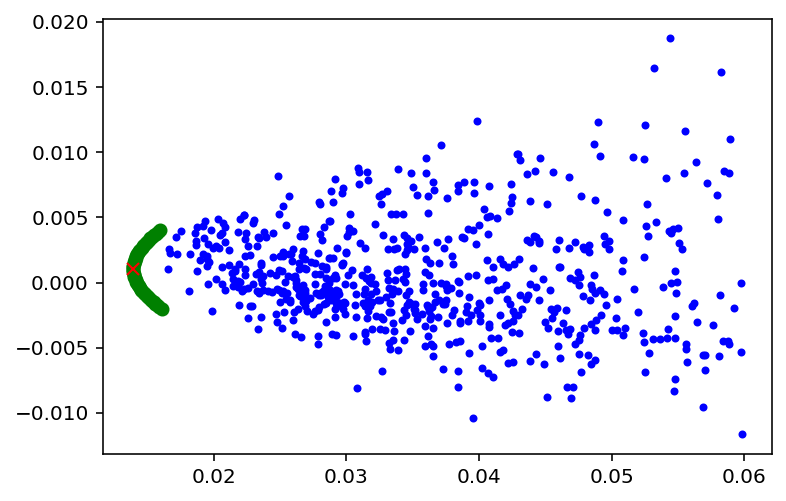

In [47]:
#Generating random portfolios
random_portfolios2 = 2.*np.random.rand(1000,Sigma2.shape[0]) -1
random_portfolios2/= random_portfolios2.sum(axis=1)[..., np.newaxis]
rand_mean2 = np.dot(random_portfolios2, mu2)
rand_sd2 = np.diag((random_portfolios2@Sigma2)@random_portfolios2.T)**0.5

#Calculating mean and variance of minimal varaince portfolio
min_var_mean2 = np.dot(min_var_p2, mu2)
min_var_sd2 = min_var_p.dot(Sigma2).dot(min_var_p2.T)**0.5
print(min_var_sd2, min_var_mean2)
max_sd_plot=0.06

#Making the plot
plt.plot(rand_sd2[rand_sd2 <max_sd_plot], rand_mean2[rand_sd2 < max_sd_plot], 'b.')
plt.plot(sd2_mvf, mu2_mvf, 'go')
plt.plot(min_var_sd2, min_var_mean2, 'rx')

Note that with this data, the mean variance frontier achieves the same returns with much smaller variance.

How does the efficient portfolio calculated with the data of the first part do on this second part?

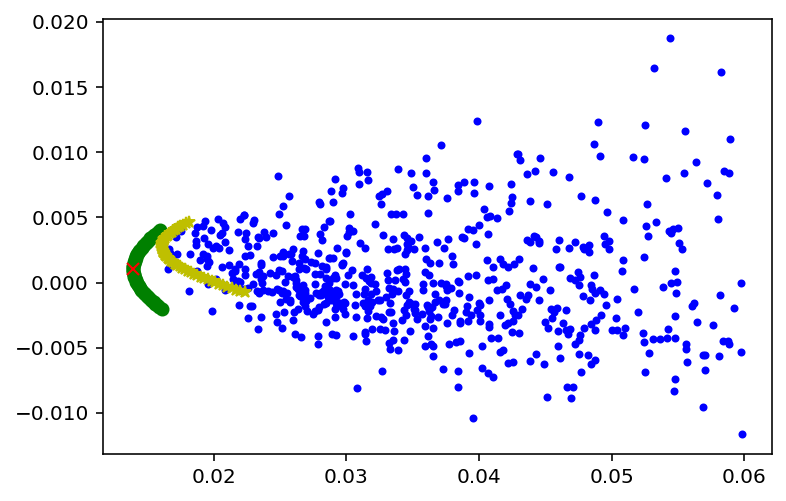

In [48]:
#Making the plot

mu1in2_mvf = mvf_portfolios @ mu2
sd1in2_mvf = np.diag((( mvf_portfolios @ Sigma2) @ mvf_portfolios.T ))**0.5



plt.plot(rand_sd2[rand_sd2 <max_sd_plot], rand_mean2[rand_sd2 < max_sd_plot], 'b.')
plt.plot(sd2_mvf, mu2_mvf, 'go')
plt.plot(sd1in2_mvf, mu1in2_mvf, 'y*')
plt.plot(min_var_sd2, min_var_mean2, 'rx')

We can see that the efficient part of the frontier is not doing that bad.

Let us move forward in time a couple of years and evaluate how these two portfolios would do in the period 2015-.

Mean: [ 3.17089980e-03  2.31414528e-03 -1.79822463e-03  2.41587099e-03
  4.18994786e-03  4.04470847e-04  1.44399790e-03  1.23922279e-03
 -2.76520721e-05]
Variances [0.00148144 0.00116645 0.00096945 0.00032701 0.00095902 0.00035725
 0.00046562 0.00068835 0.00048457]
Var-cov: [[1.48144347e-03 1.16573124e-03 4.35206897e-04 1.81572602e-04
  4.49598304e-04 7.74107987e-05 1.37466132e-04 1.28871207e-04
  3.04613149e-04]
 [1.16573124e-03 1.16644598e-03 4.71421081e-04 1.88652743e-04
  4.15244861e-04 1.25625235e-04 1.65589075e-04 7.98007726e-05
  2.87273708e-04]
 [4.35206897e-04 4.71421081e-04 9.69450039e-04 2.12555959e-04
  2.65003065e-04 1.66592903e-04 2.40478405e-04 8.25903973e-06
  2.70597336e-04]
 [1.81572602e-04 1.88652743e-04 2.12555959e-04 3.27014030e-04
  2.42208339e-04 1.52696242e-04 1.02605747e-04 1.18529988e-04
  1.36443676e-04]
 [4.49598304e-04 4.15244861e-04 2.65003065e-04 2.42208339e-04
  9.59021380e-04 2.65334278e-04 1.44848437e-04 2.23905822e-04
  2.17360718e-04]
 [7.74107987e-0

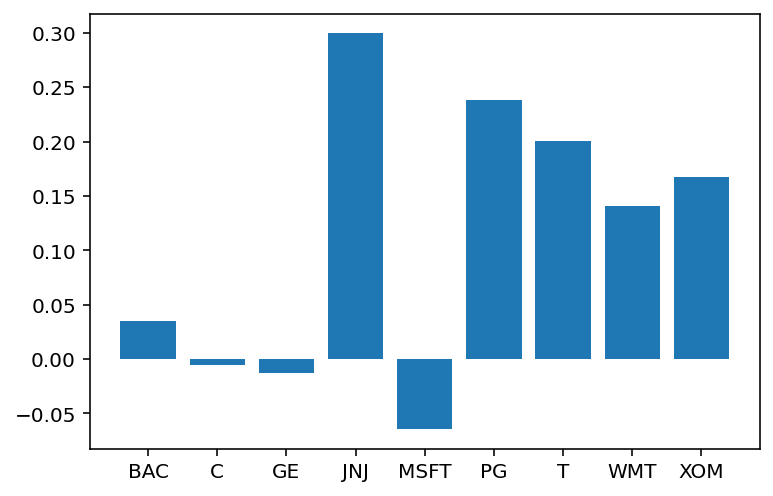

In [49]:
R_sub3 = R[(R.index> '2015-01-01')]
mu3 = R_sub3.mean().values
Sigma3 = R_sub3.cov().values
Rho3 = R_sub3.corr().values

print('Mean:', mu3)
print('Variances', np.diag(Sigma3))
print('Var-cov:', Sigma3)
print('Correlation', Rho3)

mvf_portfolios3 = Markowitz_weights(Sigma3, mu3, mup)
mu3_mvf = mvf_portfolios3 @ mu3
sd3_mvf = np.diag((( mvf_portfolios3 @ Sigma3) @ mvf_portfolios3.T ))**0.5

print(np.linalg.cond(Sigma3))
sigma3_inv = np.linalg.inv(Sigma3)
ones_vec = np.ones(Sigma3.shape[0])
min_var_p3 =  sigma3_inv@ones_vec
min_var_p3/=min_var_p3.sum()
plt.bar(R.columns, min_var_p3)
print(R.columns)
print(min_var_p3)


0.013478190320770416 0.0011343138763670057


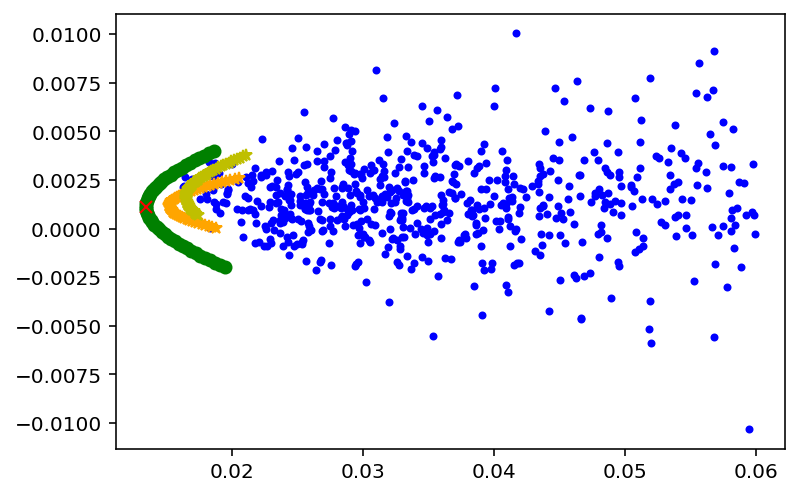

In [50]:
#Generating random portfolios
random_portfolios3 = 2.*np.random.rand(1000,Sigma3.shape[0]) -1
random_portfolios3/= random_portfolios3.sum(axis=1)[..., np.newaxis]
rand_mean3 = np.dot(random_portfolios3, mu3)
rand_sd3 = np.diag((random_portfolios3@Sigma2)@random_portfolios3.T)**0.5

#Calculating mean and variance of minimal varaince portfolio
min_var_mean3 = np.dot(min_var_p3, mu3)
min_var_sd3 = min_var_p.dot(Sigma3).dot(min_var_p3.T)**0.5
print(min_var_sd3, min_var_mean3)
max_sd_plot=0.06

#Calculating results of previous optimals

mu2in3_mvf = mvf_portfolios2 @ mu3
sd2in3_mvf = np.diag((( mvf_portfolios2 @ Sigma3) @ mvf_portfolios2.T ))**0.5

mu1in3_mvf = mvf_portfolios @ mu3
sd1in3_mvf = np.diag((( mvf_portfolios @ Sigma3) @ mvf_portfolios.T ))**0.5



#Making the plot
plt.plot(rand_sd3[rand_sd3 <max_sd_plot], rand_mean3[rand_sd3 < max_sd_plot], 'b.')
plt.plot(sd3_mvf, mu3_mvf, 'go')
plt.plot(min_var_sd3, min_var_mean3, 'rx')
plt.plot(sd1in3_mvf, mu1in3_mvf, '*', color='orange')
plt.plot(sd2in3_mvf, mu2in3_mvf, 'y*')



Note that the efficient portfolios calculated with the first data-base (all before 2010) are subperforming (even if they are not that bad). This shows that periodic recalculation is needed. If trading costs are important, this might reduce the possibilities to keep true efficient portfolios in time.